In [1]:
%reset -f
import sys
sys.path.insert(0,'..')
from wavhandler import *
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from utils import get_classifier
import xgboost
import seaborn as sns
from utils_train import test_inds, test_days
register_matplotlib_converters()

In [2]:
# test_days

Data: P_Cichorii.
Read 1600 filenames in 0.18 seconds.
Loaded data into matrix in 0.65 seconds.
581 filenames after cleaning.
156 test data.


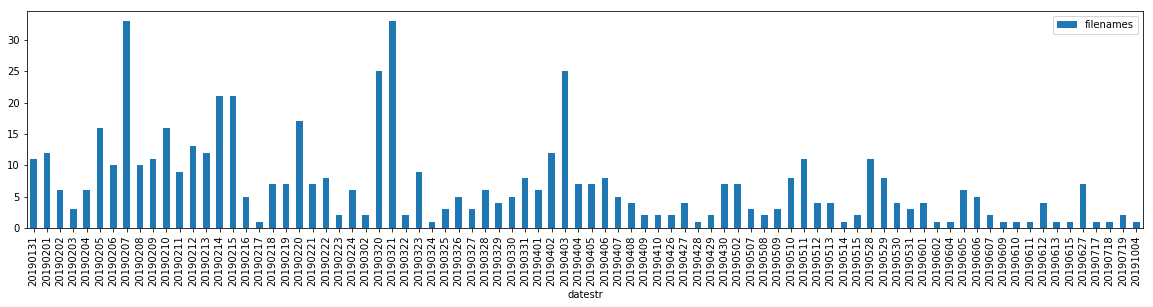

In [3]:
data1 = Dataset('Leafminers')
data1.read(data=data1.target_classes[0], setting='psd_dB')
data1.clean(threshold=10, plot=False)
dates = test_days(data1, pct=0.25)[0]
inds_1 = test_inds(data1, dates=dates)

Data: LG_drosophila_10_09.
Read 5536 filenames in 0.14 seconds.
Loaded data into matrix in 1.41 seconds.
1732 filenames after cleaning.
337 test data.


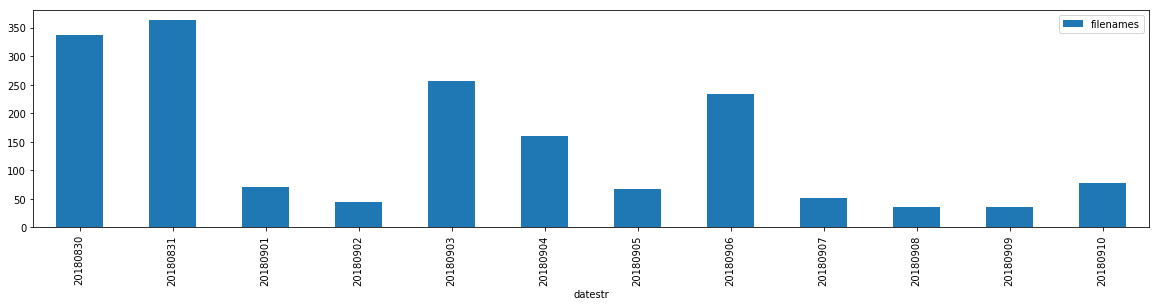

In [4]:
data2 = Dataset('LG')
data2.read(data=data2.target_classes[0], setting='psd_dB')
data2.clean(threshold=10, plot=False)
dates = test_days(data2)[0]
inds_2 = test_inds(data2, dates=dates, plot=True);

Data: LG_zapr_26_09.
Read 7210 filenames in 0.11 seconds.
Loaded data into matrix in 1.54 seconds.
3343 filenames after cleaning.
695 test data.


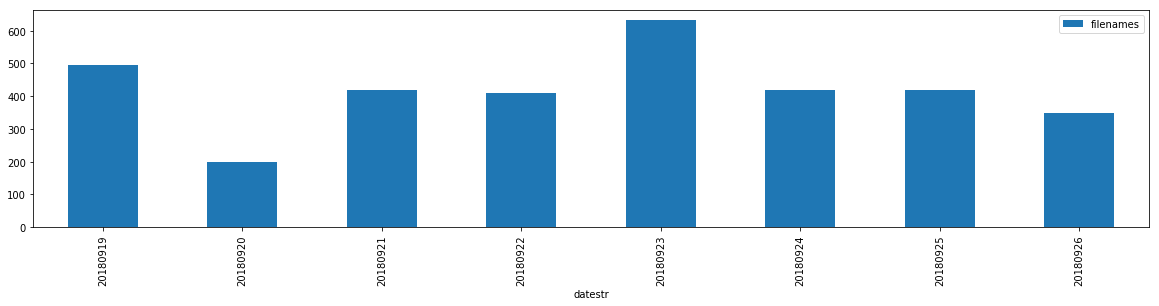

In [5]:
data3 = Dataset('LG')
data3.read(data=data3.target_classes[1], setting='psd_dB')
data3.clean(threshold=10)
inds_3 = test_inds(data3, dates=test_days(data3)[0], plot=True);

Data: D. suzukii.
Read 10493 filenames in 0.10 seconds.
Loaded data into matrix in 2.16 seconds.
570 filenames after cleaning.
57 test data.


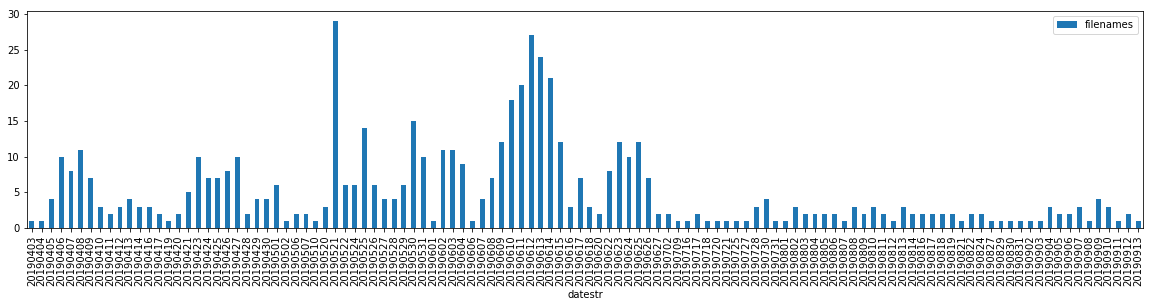

In [6]:
data4 = Dataset('Pcfruit')
data4.read(data=data4.target_classes[1], setting='psd_dB')
data4.clean(threshold=10)
inds_4 = test_inds(data4, dates=test_days(data4)[0], plot=True);

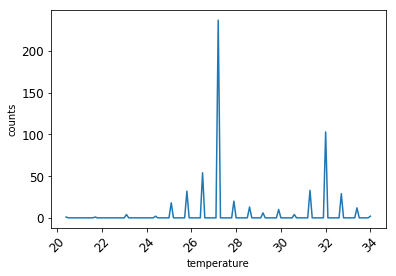

In [7]:
np_hist(data1.df_features, 'temperature')

## Creating TRAIN/VAL/TEST sets

In [8]:
def sub_test(dataset, inds):
    # Given a Dataset and some indexes (inds), return the X,y as filenames/labels 
    # that are NOT indexed by 'inds' and X_test,y_test as filenames/labels 
    # indexed by 'inds'
    X = dataset.filenames.loc[~dataset.filenames.index.isin(inds)]
    y = dataset.y.loc[~dataset.y.index.isin(inds)]
    X_test = dataset.filenames.loc[dataset.filenames.index.isin(inds)]
    y_test = dataset.y.loc[dataset.y.index.isin(inds)]
    return X, y, X_test, y_test

x1, y1, xt1, yt1 = sub_test(data1, inds_1)
x2, y2, xt2, yt2 = sub_test(data2, inds_2)
x3, y3, xt3, yt3 = sub_test(data3, inds_3)
x4, y4, xt4, yt4 = sub_test(data4, inds_4)

In [9]:
X_test = pd.concat([xt1,xt2,xt3,xt4], axis=0).tolist()
y_test = pd.concat([yt1,yt2,yt3,yt4], axis=0).tolist()

In [10]:
X = pd.concat([x1,x2,x3,x4], axis=0).tolist()
y = pd.concat([y1,y2,y3,y4], axis=0).tolist()

df = pd.DataFrame({"X": X, "y":y})
# df.drop(index=df[df['y'] == 'Ae. aegypti'].sample(38345).index.values, inplace=True)
X,y = df.X.values, df.y.values

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
y_test = le.fit_transform(y_test)

In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X,y = shuffle(X,y, random_state=0)

In [12]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, y_train = X, y

In [13]:
print(pd.Series(y_train).value_counts())
# print(pd.Series(le.inverse_transform(y_train)).value_counts())
print("classes: {}".format(le.classes_))

2    2648
1    1395
0     513
3     425
dtype: int64
classes: ['D. suzukii' 'LG_drosophila_10_09' 'LG_zapr_26_09' 'P_Cichorii']


In [14]:
np.linspace

<function numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)>

In [15]:
df_train = make_df_parallel(setting='psd_dB', names=X_train).iloc[:,7:]
# df_val = make_df_parallel(setting='psd_dB', names=X_val)#.iloc[:,70:1250]
df_test = make_df_parallel(setting='psd_dB', names=X_test).iloc[:,7:]

## k-Nearest Neighbors

Name: model, ac: 0.862651
Balanced Accuracy Score: 0.7796160141769691


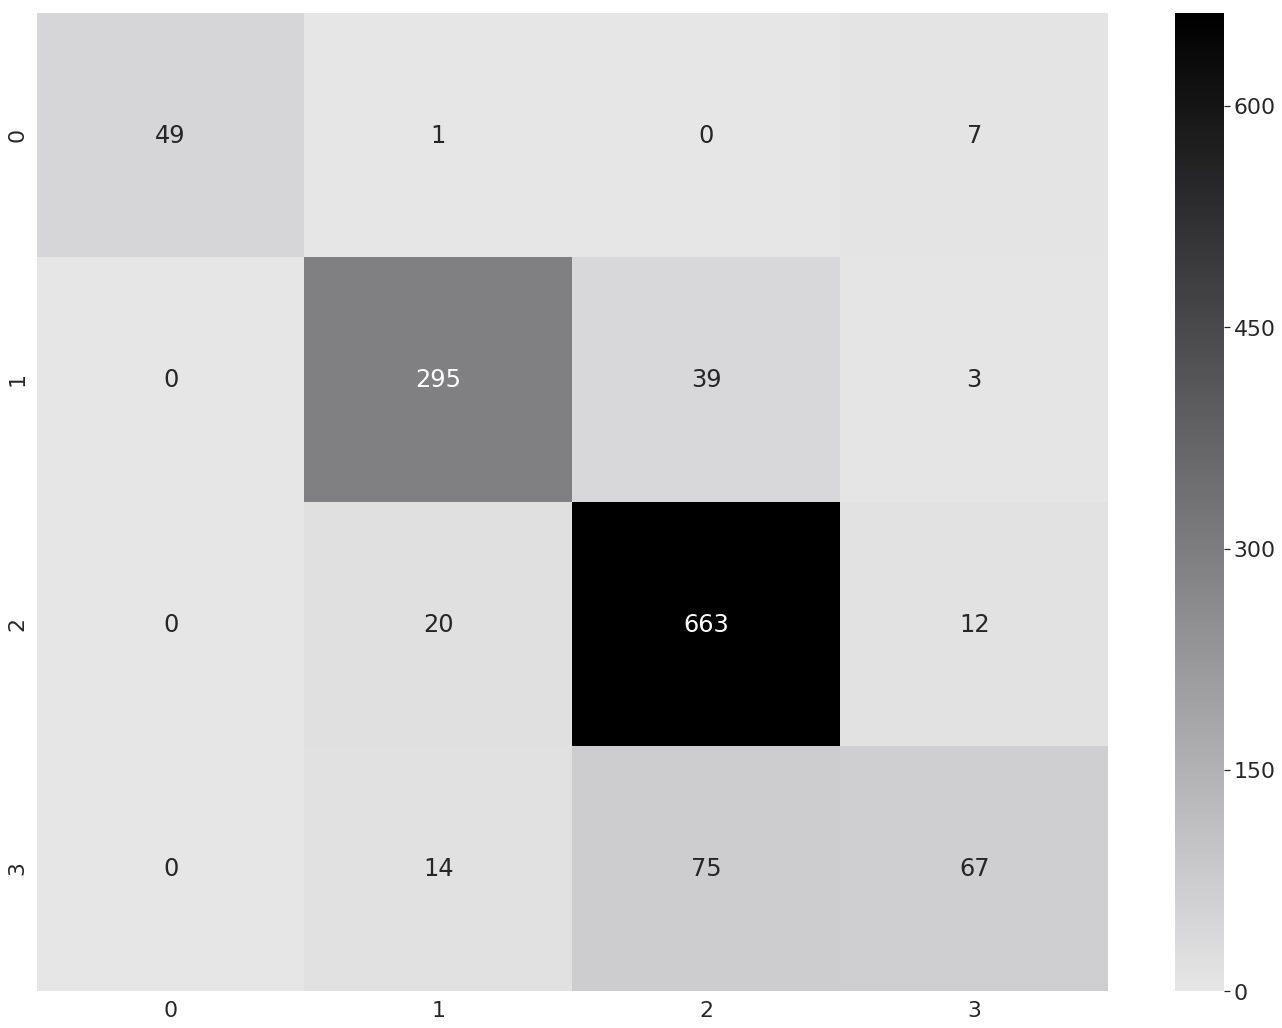

In [16]:
classifier = KNeighborsClassifier(n_neighbors = 15, p = 2)

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('model', ac))

sns.set(font_scale=2.) 

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Creating heatmap
plt.figure(figsize=(24,18))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap)

# Saving figure
# plt.savefig('/home/kalfasyan/Desktop/confusion_mat_knn.eps', format='eps')
ac = balanced_accuracy_score(y_test, y_pred)
print('Balanced Accuracy Score: {}'.format(ac))

## XGBoost

In [17]:
classifier = xgboost.XGBClassifier(n_estimators=150, 
                                   learning_rate=0.2, 
                                   n_jobs=-1,
#                                    class_weight={0:1., 1:1., 2:1., 3:5.},
                                   random_state=0)

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('model', ac))

Name: model, ac: 0.920482


Balanced Accuracy Score: 0.8803486190252258


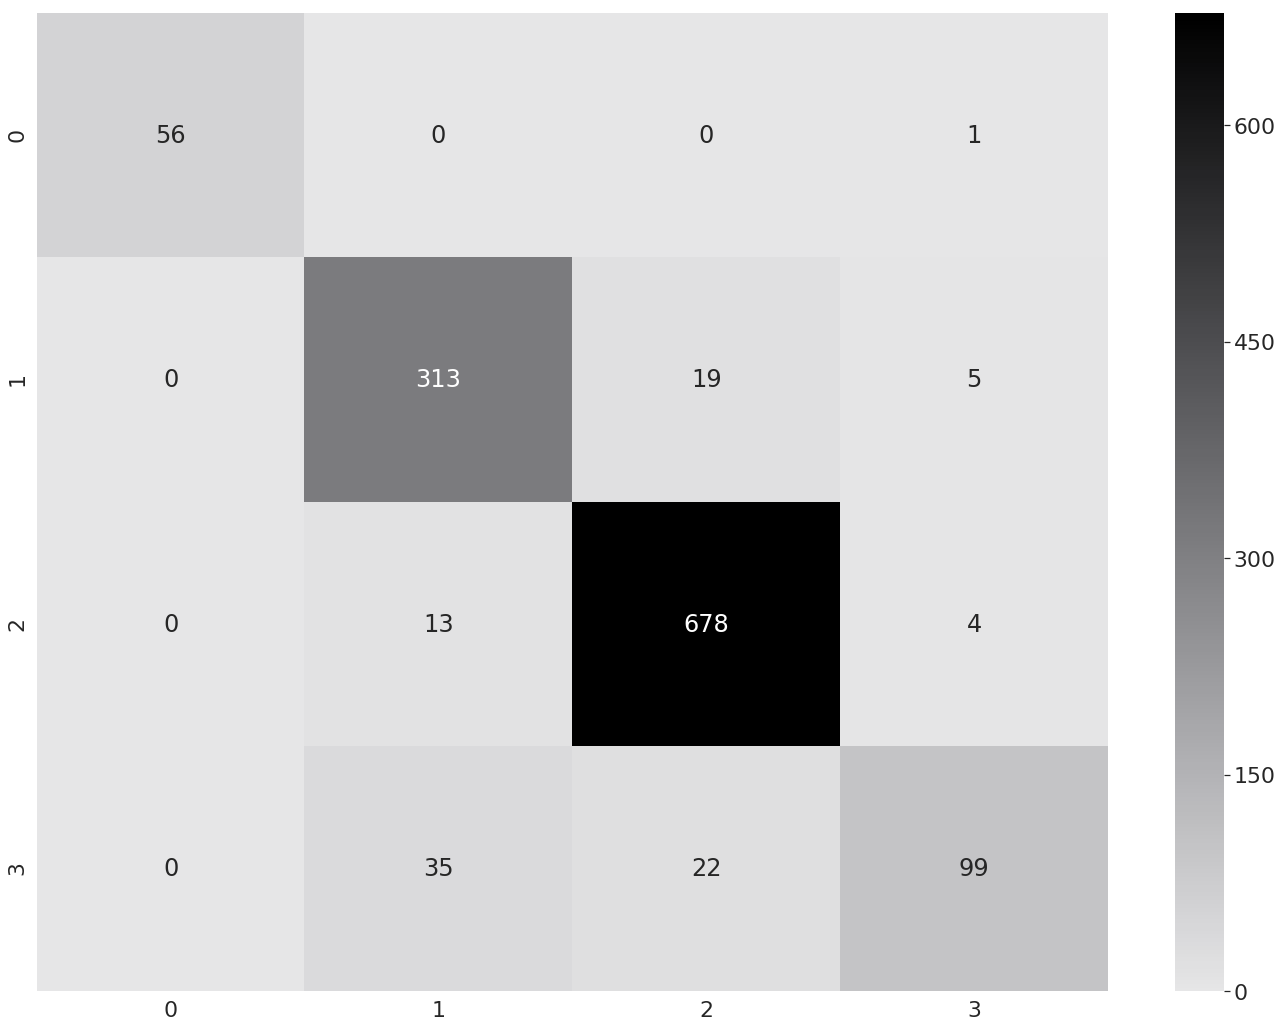

In [18]:
sns.set(font_scale=2.) 

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Creating heatmap
plt.figure(figsize=(24,18))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap)

# Saving figure
plt.savefig('/home/kalfasyan/Desktop/confusion_mat_xgboost.eps', format='eps')
ac = balanced_accuracy_score(y_test, y_pred)
print('Balanced Accuracy Score: {}'.format(ac))

# from yellowbrick.model_selection import FeatureImportances
# model = classifier
# viz = FeatureImportances(model);
# viz.fit(df_test.values, y_test);

# sub = pd.DataFrame(np.vstack((viz.features_,viz.feature_importances_))).T
# sub.columns = ['features','importances']
# sns.lineplot(x=sub.features, y=sub.importances)

## Random forest

In [19]:
# clf_name = 'rf'
# classifier = get_classifier(clf_name)
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 150, 
                                    n_jobs=-1, 
#                                     class_weight={0:50., 1:1., 2:1., 3:1.}, 
                                    random_state = 0)

classifier.fit(df_train.values, y_train)
y_pred = classifier.predict(df_test.values)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('model', ac))


Name: model, ac: 0.903614


Balanced Accuracy Score: 0.847173369678937


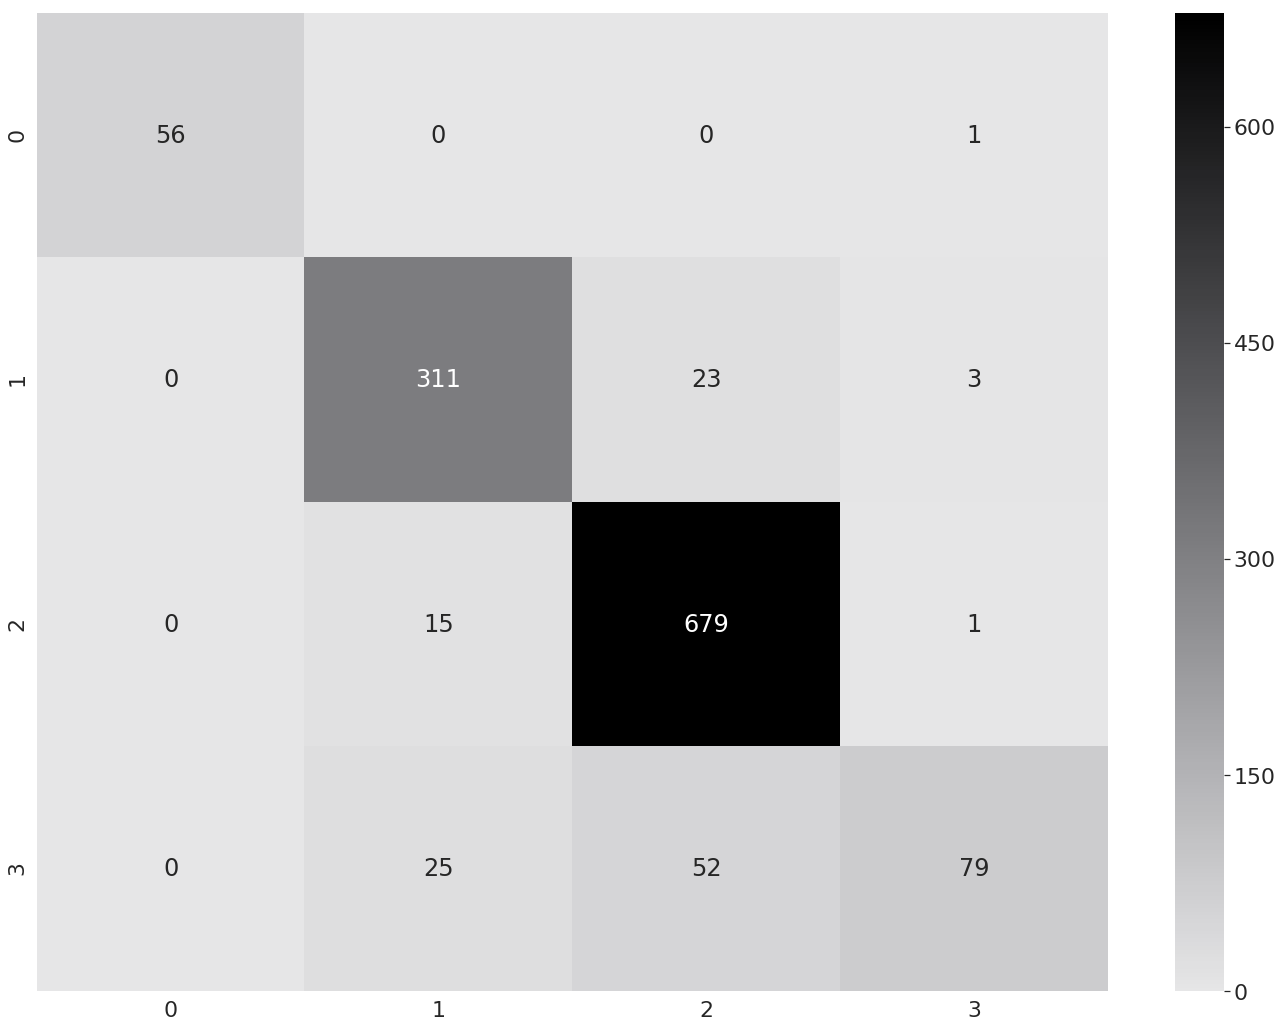

In [20]:
sns.set(font_scale=2.) 

# Calculating confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Creating heatmap
plt.figure(figsize=(24,18))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(cm, annot=True, fmt='g', cmap=cmap)

# Saving figure
plt.savefig('/home/kalfasyan/Desktop/confusion_mat.eps', format='eps')
ac = balanced_accuracy_score(y_test, y_pred)
print('Balanced Accuracy Score: {}'.format(ac))

# from yellowbrick.model_selection import FeatureImportances
# model = classifier
# viz = FeatureImportances(model);
# viz.fit(df_test.values, y_test);

# sub = pd.DataFrame(np.vstack((viz.features_,viz.feature_importances_))).T
# sub.columns = ['features','importances']
# sns.lineplot(x=sub.features, y=sub.importances)

In [21]:
pd.Series(le.inverse_transform(y_test)).value_counts()

LG_zapr_26_09          695
LG_drosophila_10_09    337
P_Cichorii             156
D. suzukii              57
dtype: int64

In [22]:
pd.Series(y_test).value_counts()

2    695
1    337
3    156
0     57
dtype: int64

In [31]:
data4.get_sensor_features()

(570, 9)


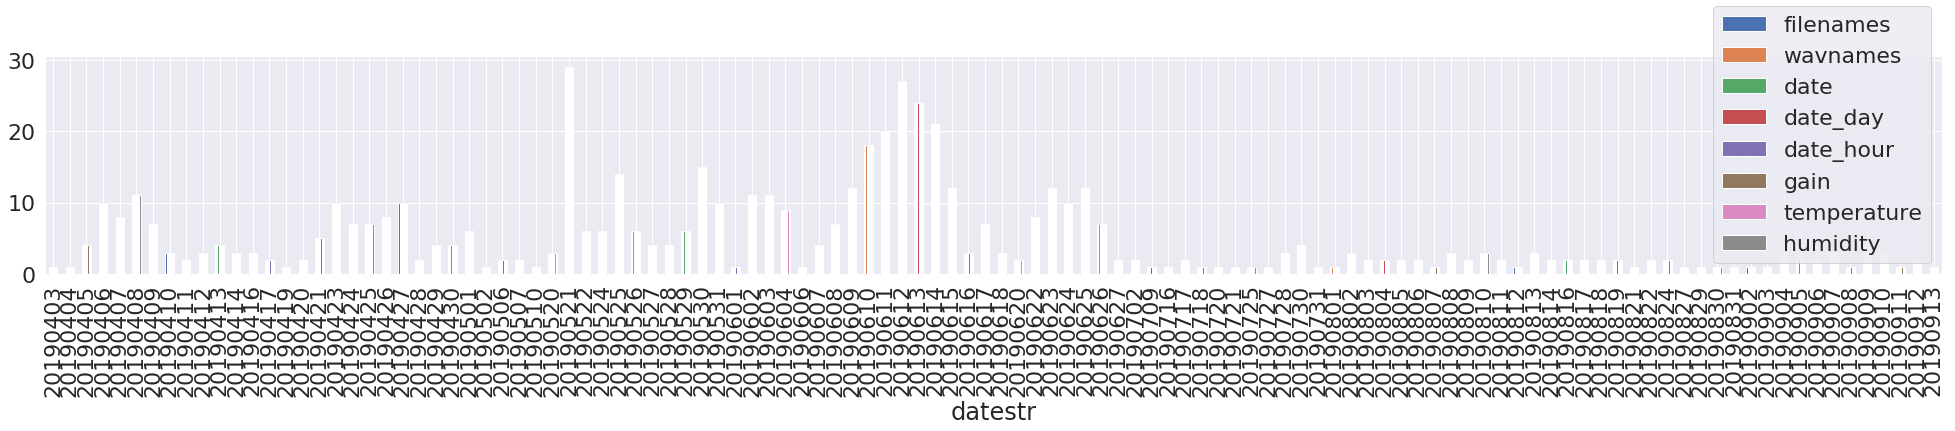

In [40]:
df = data4.df_features
print(df.shape)
df.groupby('datestr').count().plot(kind="bar", figsize=(34,4))